In [1]:
from data_gen import generate_random_shapes_image, blur_image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
from pathlib import Path
from tqdm import tqdm
import torch.amp
import seaborn as sns
from matplotlib import pyplot as plt
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
sigma_range=(0, 10)
sigma_mean = (sigma_range[1] - sigma_range[0]) / 2
sigma_std = (sigma_range[1] - sigma_range[0]) / 2
# Custom Dataset
class BlurDataset(Dataset):
    def __init__(self,  length=10000):
        self.length = length

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        image = generate_random_shapes_image()

        # Convert to numpy for OpenCV blur
        image_np = np.asarray(image)

        # Generate random sigma and apply Gaussian blur
        sigma = np.random.uniform(sigma_range[0], sigma_range[1])
        blurred = blur_image(image_np, sigma)
        blurred_pil = Image.fromarray(blurred)  # Convert back to PIL for transforms

        blurred_tensor = transform(blurred_pil)

        if blurred_tensor.shape != (1, 128, 128):
            raise ValueError(f"Unexpected tensor shape: {blurred_tensor.shape}")

        # Normalize sigma to be between 0 and 1

        sigma_normalized = (sigma - sigma_mean) / sigma_std
        return blurred_tensor, torch.tensor(sigma_normalized, dtype=torch.float32)


# CNN Model
class BlurRegressionCNN(nn.Module):
    def __init__(self):
        super(BlurRegressionCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(32),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        return x.squeeze(-1)


# Training function
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-2)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    scaler = torch.amp.GradScaler("cuda")

    best_val_loss = float("inf")
    model_path = "best_blur_model.pth"

    losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, sigmas in tqdm(
            train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"
        ):
            images, sigmas = images.to(device), sigmas.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast("cuda"):
                outputs = model(images)
                loss = criterion(outputs, sigmas)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, sigmas in val_loader:
                images, sigmas = images.to(device), sigmas.to(device)
                outputs = model(images)
                loss = criterion(outputs, sigmas)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        losses.append((train_loss, val_loss))
        print(
            f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
        )

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_path)
            print(f"Saved best model with Val Loss: {val_loss:.4f}")

        scheduler.step()
    plt.plot([l[0] for l in losses], label="Training Loss")
    plt.plot([l[1] for l in losses], label="Validation Loss")
    plt.legend()
    plt.yscale("log")
    plt.show()

    return model


def main():
    # Hyperparameters
    batch_size = 128
    num_epochs = 100
    learning_rate = 1e-3
    val_split = 0.2

    # Dataset
    dataset = BlurDataset(length=12800)

    # Split into train and validation
    train_size = int((1 - val_split) * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size]
    )

    # DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    global model
    # Model
    model = BlurRegressionCNN().to(device)

    # Train
    model = train_model(model, train_loader, val_loader, num_epochs, learning_rate)

    print("Training completed!")



cpu


Epoch 1/100: 100%|██████████| 80/80 [00:09<00:00,  8.01it/s]


Epoch 1/100, Train Loss: 0.2504, Val Loss: 0.1542
Saved best model with Val Loss: 0.1542


Epoch 2/100: 100%|██████████| 80/80 [00:08<00:00,  8.95it/s]


Epoch 2/100, Train Loss: 0.1406, Val Loss: 0.1261
Saved best model with Val Loss: 0.1261


Epoch 3/100: 100%|██████████| 80/80 [00:09<00:00,  8.40it/s]


Epoch 3/100, Train Loss: 0.0999, Val Loss: 0.0749
Saved best model with Val Loss: 0.0749


Epoch 4/100: 100%|██████████| 80/80 [00:09<00:00,  8.43it/s]


Epoch 4/100, Train Loss: 0.0843, Val Loss: 0.0851


Epoch 5/100: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]


Epoch 5/100, Train Loss: 0.0768, Val Loss: 0.0958


Epoch 6/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 6/100, Train Loss: 0.0723, Val Loss: 0.0623
Saved best model with Val Loss: 0.0623


Epoch 7/100: 100%|██████████| 80/80 [00:10<00:00,  7.81it/s]


Epoch 7/100, Train Loss: 0.0704, Val Loss: 0.0564
Saved best model with Val Loss: 0.0564


Epoch 8/100: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]


Epoch 8/100, Train Loss: 0.0675, Val Loss: 0.0542
Saved best model with Val Loss: 0.0542


Epoch 9/100: 100%|██████████| 80/80 [00:08<00:00,  8.95it/s]


Epoch 9/100, Train Loss: 0.0628, Val Loss: 0.0957


Epoch 10/100: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]


Epoch 10/100, Train Loss: 0.0663, Val Loss: 0.0516
Saved best model with Val Loss: 0.0516


Epoch 11/100: 100%|██████████| 80/80 [00:09<00:00,  8.71it/s]


Epoch 11/100, Train Loss: 0.0576, Val Loss: 0.0503
Saved best model with Val Loss: 0.0503


Epoch 12/100: 100%|██████████| 80/80 [00:08<00:00,  9.17it/s]


Epoch 12/100, Train Loss: 0.0611, Val Loss: 0.0565


Epoch 13/100: 100%|██████████| 80/80 [00:09<00:00,  8.25it/s]


Epoch 13/100, Train Loss: 0.0620, Val Loss: 0.0524


Epoch 14/100: 100%|██████████| 80/80 [00:09<00:00,  8.27it/s]


Epoch 14/100, Train Loss: 0.0579, Val Loss: 0.0660


Epoch 15/100: 100%|██████████| 80/80 [00:09<00:00,  8.37it/s]


Epoch 15/100, Train Loss: 0.0547, Val Loss: 0.0515


Epoch 16/100: 100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


Epoch 16/100, Train Loss: 0.0516, Val Loss: 0.0451
Saved best model with Val Loss: 0.0451


Epoch 17/100: 100%|██████████| 80/80 [00:10<00:00,  7.85it/s]


Epoch 17/100, Train Loss: 0.0521, Val Loss: 0.0547


Epoch 18/100: 100%|██████████| 80/80 [00:08<00:00,  9.09it/s]


Epoch 18/100, Train Loss: 0.0546, Val Loss: 0.0450
Saved best model with Val Loss: 0.0450


Epoch 19/100: 100%|██████████| 80/80 [00:09<00:00,  8.10it/s]


Epoch 19/100, Train Loss: 0.0567, Val Loss: 0.0581


Epoch 20/100: 100%|██████████| 80/80 [00:10<00:00,  7.80it/s]


Epoch 20/100, Train Loss: 0.0502, Val Loss: 0.0481


Epoch 21/100: 100%|██████████| 80/80 [00:09<00:00,  8.31it/s]


Epoch 21/100, Train Loss: 0.0509, Val Loss: 0.0542


Epoch 22/100: 100%|██████████| 80/80 [00:09<00:00,  8.36it/s]


Epoch 22/100, Train Loss: 0.0508, Val Loss: 0.0461


Epoch 23/100: 100%|██████████| 80/80 [00:09<00:00,  8.24it/s]


Epoch 23/100, Train Loss: 0.0518, Val Loss: 0.0566


Epoch 24/100: 100%|██████████| 80/80 [00:09<00:00,  8.17it/s]


Epoch 24/100, Train Loss: 0.0473, Val Loss: 0.0432
Saved best model with Val Loss: 0.0432


Epoch 25/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 25/100, Train Loss: 0.0470, Val Loss: 0.0444


Epoch 26/100: 100%|██████████| 80/80 [00:09<00:00,  8.14it/s]


Epoch 26/100, Train Loss: 0.0477, Val Loss: 0.0429
Saved best model with Val Loss: 0.0429


Epoch 27/100: 100%|██████████| 80/80 [00:32<00:00,  2.48it/s]


Epoch 27/100, Train Loss: 0.0459, Val Loss: 0.0578


Epoch 28/100: 100%|██████████| 80/80 [00:11<00:00,  6.84it/s]


Epoch 28/100, Train Loss: 0.0465, Val Loss: 0.0446


Epoch 29/100: 100%|██████████| 80/80 [00:09<00:00,  8.53it/s]


Epoch 29/100, Train Loss: 0.0459, Val Loss: 0.0489


Epoch 30/100: 100%|██████████| 80/80 [00:09<00:00,  8.23it/s]


Epoch 30/100, Train Loss: 0.0467, Val Loss: 0.0435


Epoch 31/100: 100%|██████████| 80/80 [00:09<00:00,  8.14it/s]


Epoch 31/100, Train Loss: 0.0453, Val Loss: 0.0363
Saved best model with Val Loss: 0.0363


Epoch 32/100: 100%|██████████| 80/80 [00:09<00:00,  8.63it/s]


Epoch 32/100, Train Loss: 0.0461, Val Loss: 0.0491


Epoch 33/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 33/100, Train Loss: 0.0452, Val Loss: 0.0413


Epoch 34/100: 100%|██████████| 80/80 [00:09<00:00,  8.65it/s]


Epoch 34/100, Train Loss: 0.0441, Val Loss: 0.0407


Epoch 35/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 35/100, Train Loss: 0.0425, Val Loss: 0.0374


Epoch 36/100: 100%|██████████| 80/80 [00:08<00:00,  9.34it/s]


Epoch 36/100, Train Loss: 0.0431, Val Loss: 0.0453


Epoch 37/100: 100%|██████████| 80/80 [00:09<00:00,  8.11it/s]


Epoch 37/100, Train Loss: 0.0417, Val Loss: 0.0334
Saved best model with Val Loss: 0.0334


Epoch 38/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 38/100, Train Loss: 0.0394, Val Loss: 0.0341


Epoch 39/100: 100%|██████████| 80/80 [00:09<00:00,  8.42it/s]


Epoch 39/100, Train Loss: 0.0429, Val Loss: 0.0578


Epoch 40/100: 100%|██████████| 80/80 [00:09<00:00,  8.48it/s]


Epoch 40/100, Train Loss: 0.0418, Val Loss: 0.0468


Epoch 41/100: 100%|██████████| 80/80 [00:09<00:00,  8.61it/s]


Epoch 41/100, Train Loss: 0.0399, Val Loss: 0.0346


Epoch 42/100: 100%|██████████| 80/80 [00:11<00:00,  7.05it/s]


Epoch 42/100, Train Loss: 0.0426, Val Loss: 0.0451


Epoch 43/100: 100%|██████████| 80/80 [00:30<00:00,  2.64it/s]


Epoch 43/100, Train Loss: 0.0423, Val Loss: 0.0378


Epoch 44/100: 100%|██████████| 80/80 [00:23<00:00,  3.42it/s]


Epoch 44/100, Train Loss: 0.0420, Val Loss: 0.0564


Epoch 45/100: 100%|██████████| 80/80 [00:22<00:00,  3.53it/s]


Epoch 45/100, Train Loss: 0.0412, Val Loss: 0.0382


Epoch 46/100: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s]


Epoch 46/100, Train Loss: 0.0427, Val Loss: 0.0326
Saved best model with Val Loss: 0.0326


Epoch 47/100: 100%|██████████| 80/80 [00:20<00:00,  3.95it/s]


Epoch 47/100, Train Loss: 0.0372, Val Loss: 0.0450


Epoch 48/100: 100%|██████████| 80/80 [00:20<00:00,  3.82it/s]


Epoch 48/100, Train Loss: 0.0366, Val Loss: 0.0359


Epoch 49/100: 100%|██████████| 80/80 [00:20<00:00,  3.85it/s]


Epoch 49/100, Train Loss: 0.0380, Val Loss: 0.0370


Epoch 50/100: 100%|██████████| 80/80 [00:22<00:00,  3.48it/s]


Epoch 50/100, Train Loss: 0.0387, Val Loss: 0.0420


Epoch 51/100: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s]


Epoch 51/100, Train Loss: 0.0366, Val Loss: 0.0363


Epoch 52/100: 100%|██████████| 80/80 [00:21<00:00,  3.66it/s]


Epoch 52/100, Train Loss: 0.0361, Val Loss: 0.0332


Epoch 53/100: 100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Epoch 53/100, Train Loss: 0.0370, Val Loss: 0.0383


Epoch 54/100: 100%|██████████| 80/80 [00:22<00:00,  3.55it/s]


Epoch 54/100, Train Loss: 0.0378, Val Loss: 0.0340


Epoch 55/100: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


Epoch 55/100, Train Loss: 0.0349, Val Loss: 0.0348


Epoch 56/100: 100%|██████████| 80/80 [00:23<00:00,  3.38it/s]


Epoch 56/100, Train Loss: 0.0379, Val Loss: 0.0393


Epoch 57/100: 100%|██████████| 80/80 [00:21<00:00,  3.66it/s]


Epoch 57/100, Train Loss: 0.0363, Val Loss: 0.0432


Epoch 58/100: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s]


Epoch 58/100, Train Loss: 0.0360, Val Loss: 0.0340


Epoch 59/100: 100%|██████████| 80/80 [00:17<00:00,  4.61it/s]


Epoch 59/100, Train Loss: 0.0393, Val Loss: 0.0359


Epoch 60/100: 100%|██████████| 80/80 [00:09<00:00,  8.26it/s]


Epoch 60/100, Train Loss: 0.0360, Val Loss: 0.0318
Saved best model with Val Loss: 0.0318


Epoch 61/100: 100%|██████████| 80/80 [00:09<00:00,  8.64it/s]


Epoch 61/100, Train Loss: 0.0377, Val Loss: 0.0363


Epoch 62/100: 100%|██████████| 80/80 [00:09<00:00,  8.67it/s]


Epoch 62/100, Train Loss: 0.0348, Val Loss: 0.0331


Epoch 63/100: 100%|██████████| 80/80 [00:09<00:00,  8.27it/s]


Epoch 63/100, Train Loss: 0.0343, Val Loss: 0.0300
Saved best model with Val Loss: 0.0300


Epoch 64/100: 100%|██████████| 80/80 [00:09<00:00,  8.62it/s]


Epoch 64/100, Train Loss: 0.0337, Val Loss: 0.0318


Epoch 65/100: 100%|██████████| 80/80 [00:09<00:00,  8.38it/s]


Epoch 65/100, Train Loss: 0.0338, Val Loss: 0.0313


Epoch 66/100: 100%|██████████| 80/80 [00:09<00:00,  8.50it/s]


Epoch 66/100, Train Loss: 0.0330, Val Loss: 0.0374


Epoch 67/100: 100%|██████████| 80/80 [00:08<00:00,  9.54it/s]


Epoch 67/100, Train Loss: 0.0346, Val Loss: 0.0294
Saved best model with Val Loss: 0.0294


Epoch 68/100: 100%|██████████| 80/80 [00:09<00:00,  8.58it/s]


Epoch 68/100, Train Loss: 0.0331, Val Loss: 0.0379


Epoch 69/100: 100%|██████████| 80/80 [00:09<00:00,  8.35it/s]


Epoch 69/100, Train Loss: 0.0327, Val Loss: 0.0273
Saved best model with Val Loss: 0.0273


Epoch 70/100: 100%|██████████| 80/80 [00:09<00:00,  8.22it/s]


Epoch 70/100, Train Loss: 0.0344, Val Loss: 0.0301


Epoch 71/100: 100%|██████████| 80/80 [00:09<00:00,  8.55it/s]


Epoch 71/100, Train Loss: 0.0341, Val Loss: 0.0305


Epoch 72/100: 100%|██████████| 80/80 [00:08<00:00,  8.91it/s]


Epoch 72/100, Train Loss: 0.0338, Val Loss: 0.0291


Epoch 73/100: 100%|██████████| 80/80 [00:09<00:00,  8.74it/s]


Epoch 73/100, Train Loss: 0.0316, Val Loss: 0.0286


Epoch 74/100: 100%|██████████| 80/80 [00:09<00:00,  8.56it/s]


Epoch 74/100, Train Loss: 0.0335, Val Loss: 0.0285


Epoch 75/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 75/100, Train Loss: 0.0326, Val Loss: 0.0287


Epoch 76/100: 100%|██████████| 80/80 [00:09<00:00,  8.67it/s]


Epoch 76/100, Train Loss: 0.0326, Val Loss: 0.0270
Saved best model with Val Loss: 0.0270


Epoch 77/100: 100%|██████████| 80/80 [00:09<00:00,  8.80it/s]


Epoch 77/100, Train Loss: 0.0315, Val Loss: 0.0281


Epoch 78/100: 100%|██████████| 80/80 [00:09<00:00,  8.75it/s]


Epoch 78/100, Train Loss: 0.0323, Val Loss: 0.0288


Epoch 79/100: 100%|██████████| 80/80 [00:09<00:00,  8.81it/s]


Epoch 79/100, Train Loss: 0.0306, Val Loss: 0.0284


Epoch 80/100: 100%|██████████| 80/80 [00:09<00:00,  8.83it/s]


Epoch 80/100, Train Loss: 0.0298, Val Loss: 0.0270
Saved best model with Val Loss: 0.0270


Epoch 81/100: 100%|██████████| 80/80 [00:09<00:00,  8.78it/s]


Epoch 81/100, Train Loss: 0.0324, Val Loss: 0.0264
Saved best model with Val Loss: 0.0264


Epoch 82/100: 100%|██████████| 80/80 [00:09<00:00,  8.79it/s]


Epoch 82/100, Train Loss: 0.0320, Val Loss: 0.0328


Epoch 83/100: 100%|██████████| 80/80 [00:09<00:00,  8.74it/s]


Epoch 83/100, Train Loss: 0.0285, Val Loss: 0.0255
Saved best model with Val Loss: 0.0255


Epoch 84/100: 100%|██████████| 80/80 [00:09<00:00,  8.55it/s]


Epoch 84/100, Train Loss: 0.0294, Val Loss: 0.0262


Epoch 85/100: 100%|██████████| 80/80 [00:20<00:00,  3.97it/s]


Epoch 85/100, Train Loss: 0.0290, Val Loss: 0.0263


Epoch 86/100: 100%|██████████| 80/80 [00:20<00:00,  3.89it/s]


Epoch 86/100, Train Loss: 0.0299, Val Loss: 0.0241
Saved best model with Val Loss: 0.0241


Epoch 87/100: 100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Epoch 87/100, Train Loss: 0.0295, Val Loss: 0.0266


Epoch 88/100: 100%|██████████| 80/80 [00:21<00:00,  3.66it/s]


Epoch 88/100, Train Loss: 0.0288, Val Loss: 0.0260


Epoch 89/100: 100%|██████████| 80/80 [00:22<00:00,  3.59it/s]


Epoch 89/100, Train Loss: 0.0278, Val Loss: 0.0235
Saved best model with Val Loss: 0.0235


Epoch 90/100: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s]


Epoch 90/100, Train Loss: 0.0269, Val Loss: 0.0266


Epoch 91/100: 100%|██████████| 80/80 [00:22<00:00,  3.59it/s]


Epoch 91/100, Train Loss: 0.0302, Val Loss: 0.0249


Epoch 92/100: 100%|██████████| 80/80 [00:21<00:00,  3.68it/s]


Epoch 92/100, Train Loss: 0.0280, Val Loss: 0.0260


Epoch 93/100: 100%|██████████| 80/80 [00:23<00:00,  3.44it/s]


Epoch 93/100, Train Loss: 0.0289, Val Loss: 0.0253


Epoch 94/100: 100%|██████████| 80/80 [00:22<00:00,  3.54it/s]


Epoch 94/100, Train Loss: 0.0277, Val Loss: 0.0247


Epoch 95/100: 100%|██████████| 80/80 [00:24<00:00,  3.32it/s]


Epoch 95/100, Train Loss: 0.0305, Val Loss: 0.0265


Epoch 96/100: 100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Epoch 96/100, Train Loss: 0.0289, Val Loss: 0.0233
Saved best model with Val Loss: 0.0233


Epoch 97/100: 100%|██████████| 80/80 [00:21<00:00,  3.72it/s]


Epoch 97/100, Train Loss: 0.0287, Val Loss: 0.0229
Saved best model with Val Loss: 0.0229


Epoch 98/100: 100%|██████████| 80/80 [00:22<00:00,  3.49it/s]


Epoch 98/100, Train Loss: 0.0293, Val Loss: 0.0265


Epoch 99/100: 100%|██████████| 80/80 [00:23<00:00,  3.45it/s]


Epoch 99/100, Train Loss: 0.0299, Val Loss: 0.0244


Epoch 100/100: 100%|██████████| 80/80 [00:22<00:00,  3.58it/s]


Epoch 100/100, Train Loss: 0.0290, Val Loss: 0.0265


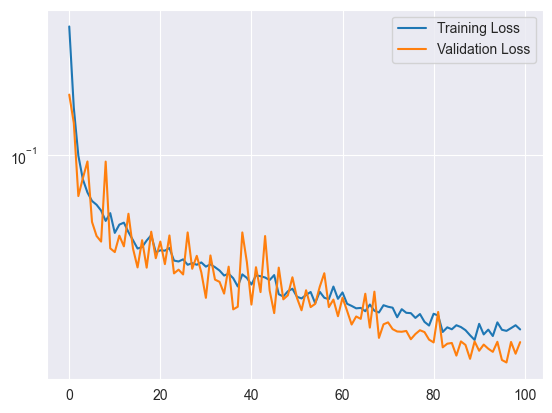

Training completed!


In [8]:
main()

In [10]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    predictions = []
    ground_truths = []

    with torch.no_grad():
        for images, sigmas in tqdm(test_loader, desc="Evaluating"):
            images, sigmas = images.to(device), sigmas.to(device)
            outputs = model(images)
            loss = criterion(outputs, sigmas)
            test_loss += loss.item() * images.size(0)

            # The normalization in BlurDataset is: sigma_normalized = (sigma - sigma_min) / (sigma_max - sigma_min)
            # So, to denormalize: sigma = sigma_normalized * (sigma_max - sigma_min) + sigma_min
            outputs_denorm = outputs.cpu().numpy() * sigma_std + sigma_mean
            sigmas_denorm = sigmas.cpu().numpy() * sigma_std + sigma_mean

            predictions.extend(outputs_denorm)
            ground_truths.extend(sigmas_denorm)

    test_loss /= len(test_loader.dataset)
    predictions = np.array(predictions)
    ground_truths = np.array(ground_truths)

    return test_loss, predictions, ground_truths


def plot_results(test_loss, predictions, ground_truths, save_dir="plots"):
    # Créer le répertoire pour sauvegarder les plots
    Path(save_dir).mkdir(exist_ok=True)

    # 1. Scatter plot : Prédictions vs Valeurs réelles
    plt.figure(figsize=(10, 6))
    plt.scatter(ground_truths, predictions, alpha=0.5, s=10)
    plt.plot([0, 10], [0, 10], 'r--', label='Ligne idéale')
    plt.xlabel('Sigma réel')
    plt.ylabel('Sigma prédit')
    plt.title(f'Prédictions vs Valeurs réelles (Test Loss: {test_loss:.4f})')
    plt.legend()
    plt.grid(True)
    plt.savefig(Path(save_dir) / 'predictions_vs_ground_truth.png')
    plt.close()


    # 2. Histogramme des erreurs
    errors = predictions - ground_truths
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel('Erreur (Prédit - Réel)')
    plt.ylabel('Fréquence')
    plt.title('Distribution des erreurs de prédiction')
    plt.grid(True)
    plt.savefig(Path(save_dir) / 'error_distribution.png')
    plt.close()


    # 3. Erreur absolue en fonction de sigma réel
    abs_errors = np.abs(errors)
    plt.figure(figsize=(10, 6))
    plt.scatter(ground_truths, abs_errors, alpha=0.5, s=10)
    plt.xlabel('Sigma réel')
    plt.ylabel('Erreur absolue')
    plt.title('Erreur absolue en fonction de Sigma réel')
    plt.grid(True)
    plt.show()

    # 4. Boxplot des erreurs par plage de sigma
    sigma_bins = np.linspace(0, 10, 11)
    digitized = np.digitize(ground_truths, sigma_bins)
    binned_errors = [abs_errors[digitized == i] for i in range(1, len(sigma_bins))]

    plt.figure(figsize=(10, 6))
    plt.boxplot(binned_errors, labels=[f'{sigma_bins[i]:.1f}-{sigma_bins[i+1]:.1f}'
                                     for i in range(len(sigma_bins)-1)])
    plt.xlabel('Plage de Sigma réel')
    plt.ylabel('Erreur absolue')
    plt.title('Distribution des erreurs par plage de Sigma')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

Evaluating:   0%|          | 0/16 [00:00<?, ?it/s]/home/matthias/Documents/TestingNNBlurDetection/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


Test Loss: 0.0283
MAE: 0.5257
RMSE: 0.8405


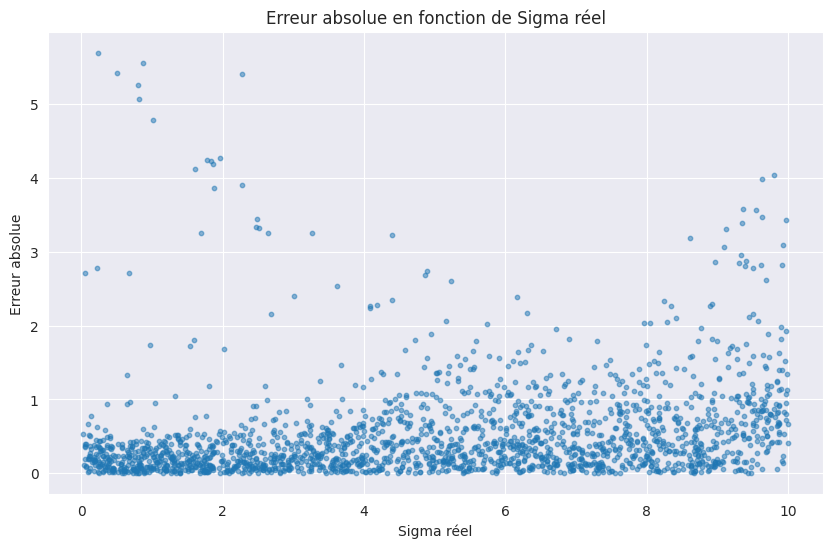

/tmp/ipykernel_12092/541332208.py:74: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(binned_errors, labels=[f'{sigma_bins[i]:.1f}-{sigma_bins[i+1]:.1f}'


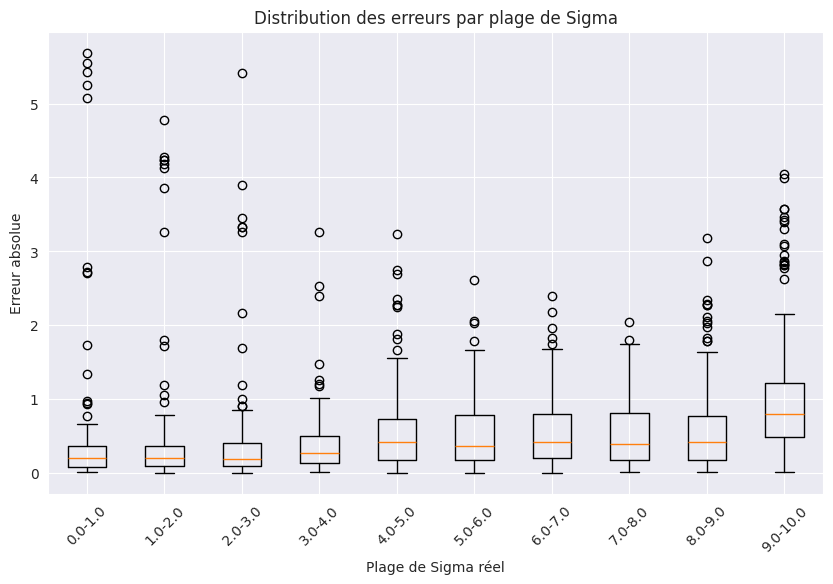

In [21]:
    # Hyperparamètres
    batch_size = 128
    sigma_range = (0, 10)
    test_size = 2000

    # Charger le modèle entraîné
    # model = BlurRegressionCNN().to(device)
    model = BlurRegressionCNN().to(device)
    model.load_state_dict(torch.load("best_blur_model.pth", map_location=torch.device('cpu')))
    # model_path = "best_blur_model.pth"
    # if not Path(model_path).exists():
    #     raise FileNotFoundError(f"Modèle non trouvé à {model_path}")
    # model.load_state_dict(torch.load(model_path))
    # print(f"Modèle chargé depuis {model_path}")

    # Créer le dataset de test
    test_dataset = BlurDataset(length=test_size)
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    # Critère de perte
    criterion = nn.MSELoss()

    # Évaluer le modèle
    test_loss, predictions, ground_truths = evaluate_model(model, test_loader, criterion)

    # Afficher les résultats
    print(f"Test Loss: {test_loss:.4f}")
    print(f"MAE: {np.mean(np.abs(predictions - ground_truths)):.4f}")
    print(f"RMSE: {np.sqrt(np.mean((predictions - ground_truths)**2)):.4f}")

    # Visualiser les résultats
    plot_results(test_loss, predictions, ground_truths)

In [2]:
import sys
import cv2
import torch
import numpy as np
from PySide6.QtWidgets import QApplication, QLabel, QVBoxLayout, QWidget
from PySide6.QtCore import QTimer, Qt
from PySide6.QtGui import QImage, QPixmap
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BlurRegressionCNN().to(device)
model.load_state_dict(torch.load("best_blur_model.pth", map_location=device))
model.eval()

# === MAIN WINDOW ===
class BlurEstimatorApp(QWidget):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Blur Estimator (Transformed Image View)")
        self.resize(300, 300)

        self.video_label = QLabel()
        self.video_label.setAlignment(Qt.AlignCenter)
        self.prediction_label = QLabel("Predicted Sigma: ...")
        self.prediction_label.setStyleSheet("font-size: 18px; color: green")
        self.prediction_label.setAlignment(Qt.AlignCenter)

        layout = QVBoxLayout()
        layout.addWidget(self.video_label)
        layout.addWidget(self.prediction_label)
        self.setLayout(layout)

        self.cap = cv2.VideoCapture(0)
        self.timer = QTimer()
        self.timer.timeout.connect(self.update_frame)
        self.timer.start(30)

    def update_frame(self):
        ret, frame = self.cap.read()
        if not ret:
            return

        # Convert to grayscale and PIL image
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        pil_img = Image.fromarray(gray)

        # Apply transform
        input_tensor = transform(pil_img).unsqueeze(0).to(device)

        # Predict blur level
        with torch.no_grad():
            output = model(input_tensor)
            sigma = output.item()
            self.prediction_label.setText(f"Predicted Sigma: {sigma:.2f}")

        # Prepare transformed image for display
        img_np = input_tensor.squeeze().detach().cpu().numpy()
        img_np = ((img_np * 0.5) + 0.5) * 255  # Denormalize
        img_np = img_np.astype(np.uint8)

        h, w = img_np.shape
        q_img = QImage(img_np.data, w, h, w, QImage.Format_Grayscale8)
        pixmap = QPixmap.fromImage(q_img).scaled(256, 256, Qt.KeepAspectRatio)

        self.video_label.setPixmap(pixmap)

    def closeEvent(self, event):
        self.cap.release()
        event.accept()


In [3]:
app = QApplication(sys.argv)
window = BlurEstimatorApp()
window.show()
sys.exit(app.exec())

SystemExit: 0

/home/matthias/Documents/TestingNNBlurDetection/.venv/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3678: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
